In [ ]:
!pip install snscrape

In [ ]:
import snscrape.modules.twitter as sntwitter
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import string

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import json, nltk
import seaborn as sns
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
train_data = pd.read_csv("Train_data.csv")
test_data = pd.read_csv("T_Test.csv")
Policy_1= pd.read_csv("Business_Restriction.csv")
Policy_2 = pd.read_csv("Health_Testing.csv")
Policy_3 = pd.read_csv("Lockdown.csv")
Policy_4 = pd.read_csv("Mask_Mandate.csv")
Policy_5 = pd.read_csv("Mass_Gathering.csv")
Policy_6 = pd.read_csv("Vaccine.csv")

In [ ]:
train_data = train_data.dropna(axis = 0)

In [ ]:
#Taking only limited amount of tweets cause SVM execution times are arbitrary and can take for ever to run
train_data = train_data.head(30000)

In [ ]:
train_data.emotion.value_counts()

fear                   14071
anger                   5597
happiness               4973
no specific emotion     4597
sadness                  762
Name: emotion, dtype: int64

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train_data["emotion"])

LabelEncoder()

In [ ]:
train_data['emotion'] = le.transform(train_data["emotion"])

In [ ]:
train_data.emotion.value_counts()

1    14071
0     5597
2     4973
3     4597
4      762
Name: emotion, dtype: int64

In [ ]:
del train_data['tweet_id']
del train_data['user_id']
del train_data['tweet_timestamp']
del train_data['keyword']
del train_data['valence_intensity']
del train_data['fear_intensity']
del train_data['anger_intensity']
del train_data['happiness_intensity']
del train_data['sadness_intensity']
del train_data['sentiment']

In [ ]:
train_data = train_data.rename(columns = {' text': 'Tweets', 'emotion': 'Analysis'}, inplace= False)

In [ ]:
tweet = train_data.columns.values[0]
sentiment = train_data.columns.values[1]
ttweet = test_data.columns.values[0]
tweet1 = Policy_1.columns.values[0]
tweet2 = Policy_2.columns.values[0]
tweet3 = Policy_3.columns.values[0]
tweet4 = Policy_4.columns.values[0]
tweet5 = Policy_5.columns.values[0]
tweet6 = Policy_6.columns.values[0]
tweet, sentiment, ttweet, tweet1, tweet2, tweet3, tweet4, tweet5, tweet6

('Tweets',
 'Analysis',
 'Tweets',
 'Tweets',
 'Tweets',
 'Tweets',
 'Tweets',
 'Tweets',
 'Tweets')

In [ ]:
def emoji(tweet):
    
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:O)', ' positiveemoji ', tweet)
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' positiveemoji ', tweet)
    tweet = re.sub(r'(<3|:\*)', ' positiveemoji ', tweet)
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;|@-\))', ' positiveemoji ', tweet)
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:|:-/|:-\|)', ' negetiveemoji ', tweet)
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' negetiveemoji ', tweet)
    return tweet

In [ ]:
import re

def process_tweet(tweet):
    tweet = tweet.lower()                                             
    tweet = re.sub('@[^\s]+', '', tweet)                              
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', tweet)   
    tweet = re.sub(r'https?:\/\/\S+', '', tweet)
    tweet = re.sub(r"\d+", " ", str(tweet))                         
    tweet = re.sub('&quot;'," ", tweet)                              
    tweet = emoji(tweet)                                              
    tweet = re.sub(r"\b[a-zA-Z]\b", "", str(tweet))                   
    #for word in tweet.split():
        #if word.lower() in contractions:
            #tweet = tweet.replace(word, contractions[word.lower()])   
    tweet = re.sub(r"[^\w\s]", " ", str(tweet))                       
    tweet = re.sub(r'(.)\1+', r'\1\1', tweet)                      
    tweet = re.sub(r"\s+", " ", str(tweet))                              
    return tweet

In [ ]:
train_data['processed_tweet'] = np.vectorize(process_tweet)(train_data[tweet])
test_data['processed_tweet'] = np.vectorize(process_tweet)(test_data[tweet])
Policy_1['processed_tweet'] = np.vectorize(process_tweet)(Policy_1[tweet])
Policy_2['processed_tweet'] = np.vectorize(process_tweet)(Policy_2[tweet])
Policy_3['processed_tweet'] = np.vectorize(process_tweet)(Policy_3[tweet])
Policy_4['processed_tweet'] = np.vectorize(process_tweet)(Policy_4[tweet])
Policy_5['processed_tweet'] = np.vectorize(process_tweet)(Policy_5[tweet])
Policy_6['processed_tweet'] = np.vectorize(process_tweet)(Policy_6[tweet])

In [ ]:
tokenized_tweet = train_data['processed_tweet'].apply(lambda x: x.split())
tokenized_ttweet = test_data['processed_tweet'].apply(lambda x: x.split())
tokenized_tweet1 = Policy_1['processed_tweet'].apply(lambda x: x.split())
tokenized_tweet2 = Policy_2['processed_tweet'].apply(lambda x: x.split())
tokenized_tweet3 = Policy_3['processed_tweet'].apply(lambda x: x.split())
tokenized_tweet4 = Policy_4['processed_tweet'].apply(lambda x: x.split())
tokenized_tweet5 = Policy_5['processed_tweet'].apply(lambda x: x.split())
tokenized_tweet6 = Policy_6['processed_tweet'].apply(lambda x: x.split())

#tokenized_ttweet.head()
#tokenized_tweet.head()

In [ ]:
# from nltk.stem.porter import *
# stemmer = PorterStemmer()

# tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
# tokenized_tweet.head()

In [ ]:
 from nltk.stem.wordnet import WordNetLemmatizer
 lemmatizer = WordNetLemmatizer()

 tokenized_tweet = tokenized_tweet.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
 tokenized_ttweet = tokenized_ttweet.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
 tokenized_tweet1 = tokenized_tweet1.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
 tokenized_tweet2 = tokenized_tweet2.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
 tokenized_tweet3 = tokenized_tweet3.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
 tokenized_tweet4 = tokenized_tweet4.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
 tokenized_tweet5 = tokenized_tweet5.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
 tokenized_tweet6 = tokenized_tweet6.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
 #tokenized_tweet.head()

In [ ]:
 train_data['processed_tweet'] = tokenized_tweet

0                         the wuhan virus how to stay safe
1                                               well mean 
2        us to expand virus screening at airports for v...
3         reports surrounding coronavirus have been cha...
4        wuhan in lock down speak with wayne dupleiss c...
                               ...                        
30181    virus hit wuhan has two laboratories linked to...
30182     eng sub chen qiushi wuhan is short of test ki...
30183     hope theyre okay and the only corona they enc...
30184                                 corona strikes again
30185           corona vaccine comes in packs or justajoke
Name: processed_tweet, Length: 30000, dtype: object

In [ ]:
nltk.download("stopwords")
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Not working**

In [ ]:
'''
 for i in range(len(tokenized_tweet)):
    
#     # Below code is used for no stop word removal
      tokenized_tweet[i] = ' '.join(tokenized_tweet[i]) 
    
#     # Used for stop word removal 
#     # (Below is commented out as sentiment analysis is giving better accuracy without removing stop words.
#     # If you still want to check, comment out the above line, uncomment the line below and run the code again.)
    
#     # tokenized_tweet[i] = ' '.join([word for word in tokenized_tweet[i] if word not in stop_words])  
    
 train_data['processed_tweet'] = tokenized_tweet

 for i in range(len(tokenized_ttweet)):
    
#     # Below code is used for no stop word removal
      tokenized_ttweet[i] = ' '.join(tokenized_ttweet[i]) 
    
#     # Used for stop word removal 
#     # (Below is commented out as sentiment analysis is giving better accuracy without removing stop words.
#     # If you still want to check, comment out the above line, uncomment the line below and run the code again.)
     
#     # tokenized_ttweet[i] = ' '.join([word for word in ttokenized_tweet[i] if word not in stop_words])  
    
 test_data['processed_tweet'] = tokenized_ttweet

 for i in range(len(tokenized_tweet1)):
    
#     # Below code is used for no stop word removal
      tokenized_tweet1[i] = ' '.join(tokenized_tweet1[i]) 
    
#     # Used for stop word removal 
#     # (Below is commented out as sentiment analysis is giving better accuracy without removing stop words.
#     # If you still want to check, comment out the above line, uncomment the line below and run the code again.)
     
#     # tokenized_tweet1[i] = ' '.join([word for word in tokenized_tweet1[i] if word not in stop_words])  
    
 Policy_1['processed_tweet'] = tokenized_tweet1

 for i in range(len(tokenized_tweet2)):
    
#     # Below code is used for no stop word removal
      tokenized_tweet2[i] = ' '.join(tokenized_tweet2[i]) 
    
#     # Used for stop word removal 
#     # (Below is commented out as sentiment analysis is giving better accuracy without removing stop words.
#     # If you still want to check, comment out the above line, uncomment the line below and run the code again.)
     
#     # tokenized_tweet2[i] = ' '.join([word for word in tokenized_tweet2[i] if word not in stop_words])  
    
 Policy_2['processed_tweet'] = tokenized_tweet2

 for i in range(len(tokenized_tweet3)):
    
#     # Below code is used for no stop word removal
      tokenized_tweet3[i] = ' '.join(tokenized_tweet3[i]) 
    
#     # Used for stop word removal 
#     # (Below is commented out as sentiment analysis is giving better accuracy without removing stop words.
#     # If you still want to check, comment out the above line, uncomment the line below and run the code again.)
     
#     # tokenized_tweet3[i] = ' '.join([word for word in tokenized_tweet3[i] if word not in stop_words])  
    
 Policy_3['processed_tweet'] = tokenized_tweet3

 for i in range(len(tokenized_tweet4)):
    
#     # Below code is used for no stop word removal
      tokenized_tweet4[i] = ' '.join(tokenized_tweet4[i]) 
    
#     # Used for stop word removal 
#     # (Below is commented out as sentiment analysis is giving better accuracy without removing stop words.
#     # If you still want to check, comment out the above line, uncomment the line below and run the code again.)
     
#     # tokenized_tweet4[i] = ' '.join([word for word in tokenized_tweet4[i] if word not in stop_words])  
    
 Policy_4['processed_tweet'] = tokenized_tweet4

 for i in range(len(tokenized_tweet5)):
    
#     # Below code is used for no stop word removal
      tokenized_tweet5[i] = ' '.join(tokenized_tweet5[i]) 
    
#     # Used for stop word removal 
#     # (Below is commented out as sentiment analysis is giving better accuracy without removing stop words.
#     # If you still want to check, comment out the above line, uncomment the line below and run the code again.)
     
#     # tokenized_tweet5[i] = ' '.join([word for word in tokenized_tweet5[i] if word not in stop_words])  
    
 Policy_5['processed_tweet'] = tokenized_tweet5

 for i in range(len(tokenized_tweet6)):
    
#     # Below code is used for no stop word removal
      tokenized_tweet6[i] = ' '.join(tokenized_tweet6[i]) 
    
#     # Used for stop word removal 
#     # (Below is commented out as sentiment analysis is giving better accuracy without removing stop words.
#     # If you still want to check, comment out the above line, uncomment the line below and run the code again.)
     
#     # tokenized_tweet6[i] = ' '.join([word for word in tokenized_tweet6[i] if word not in stop_words])  
    
 Policy_6['processed_tweet'] = tokenized_tweet6
 '''

"\n for i in range(len(tokenized_tweet)):\n    \n#     # Below code is used for no stop word removal\n      tokenized_tweet[i] = ' '.join(tokenized_tweet[i]) \n    \n#     # Used for stop word removal \n#     # (Below is commented out as sentiment analysis is giving better accuracy without removing stop words.\n#     # If you still want to check, comment out the above line, uncomment the line below and run the code again.)\n    \n#     # tokenized_tweet[i] = ' '.join([word for word in tokenized_tweet[i] if word not in stop_words])  \n    \n train_data['processed_tweet'] = tokenized_tweet\n\n for i in range(len(tokenized_ttweet)):\n    \n#     # Below code is used for no stop word removal\n      tokenized_ttweet[i] = ' '.join(tokenized_ttweet[i]) \n    \n#     # Used for stop word removal \n#     # (Below is commented out as sentiment analysis is giving better accuracy without removing stop words.\n#     # If you still want to check, comment out the above line, uncomment the line below 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(ngram_range=(1,2))    # Unigram and Bigram
final_vectorized_train_data = count_vectorizer.fit_transform(train_data['processed_tweet'])  
final_vectorized_test_data = count_vectorizer.transform(test_data['processed_tweet'])
final_vectorized_policy1_data = count_vectorizer.transform(Policy_1['processed_tweet'])
final_vectorized_policy2_data = count_vectorizer.transform(Policy_2['processed_tweet'])
final_vectorized_policy3_data = count_vectorizer.transform(Policy_3['processed_tweet'])
final_vectorized_policy4_data = count_vectorizer.transform(Policy_4['processed_tweet'])
final_vectorized_policy5_data = count_vectorizer.transform(Policy_5['processed_tweet'])
final_vectorized_policy6_data = count_vectorizer.transform(Policy_6['processed_tweet'])
final_vectorized_train_data, final_vectorized_test_data, final_vectorized_policy1_data, final_vectorized_policy2_data, final_vectorized_policy3_data, final_vectorized_policy4_data, final_vectorized_policy5_data, final_vectorized_policy6_data

(<30000x192500 sparse matrix of type '<class 'numpy.int64'>'
 	with 993835 stored elements in Compressed Sparse Row format>,
 <193262x192500 sparse matrix of type '<class 'numpy.int64'>'
 	with 3748383 stored elements in Compressed Sparse Row format>,
 <10001x192500 sparse matrix of type '<class 'numpy.int64'>'
 	with 389381 stored elements in Compressed Sparse Row format>,
 <10001x192500 sparse matrix of type '<class 'numpy.int64'>'
 	with 392959 stored elements in Compressed Sparse Row format>,
 <10001x192500 sparse matrix of type '<class 'numpy.int64'>'
 	with 380013 stored elements in Compressed Sparse Row format>,
 <10001x192500 sparse matrix of type '<class 'numpy.int64'>'
 	with 406943 stored elements in Compressed Sparse Row format>,
 <2672x192500 sparse matrix of type '<class 'numpy.int64'>'
 	with 123670 stored elements in Compressed Sparse Row format>,
 <10001x192500 sparse matrix of type '<class 'numpy.int64'>'
 	with 321827 stored elements in Compressed Sparse Row format>)

In [ ]:
clustering_policy1 = final_vectorized_policy1_data
clustering_policy2 = final_vectorized_policy2_data
clustering_policy3 = final_vectorized_policy3_data
clustering_policy4 = final_vectorized_policy4_data
clustering_policy5 = final_vectorized_policy5_data
clustering_policy6 = final_vectorized_policy6_data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(final_vectorized_train_data, train_data[sentiment],
                                                    test_size=0.2, random_state=69)

In [ ]:
from sklearn.naive_bayes import MultinomialNB  

classifier = MultinomialNB()
classifier.fit(X_train, y_train)

validation_nb = classifier.predict(X_val)

In [ ]:
score_naive = accuracy_score(validation_nb, y_val)
print("Accuracy with Naive-bayes: ",score_naive)

Accuracy with Naive-bayes:  0.60225


In [ ]:
from sklearn.svm import SVC

classifier = SVC(kernel = 'linear', random_state=0)
classifier.fit(X_train, y_train)

validation_classifier = classifier.predict(X_val)

In [ ]:
score_classifier = accuracy_score(validation_classifier, y_val)
print("Accuracy with SVM: ",score_classifier)

Accuracy with SVM:  0.635


In [ ]:
test_classifier = classifier.predict(final_vectorized_test_data)
policy1_classifier = classifier.predict(final_vectorized_policy1_data)
policy2_classifier = classifier.predict(final_vectorized_policy2_data)
policy3_classifier = classifier.predict(final_vectorized_policy3_data)
policy4_classifier = classifier.predict(final_vectorized_policy4_data)
policy5_classifier = classifier.predict(final_vectorized_policy5_data)
policy6_classifier = classifier.predict(final_vectorized_policy6_data)

In [ ]:
df = pd.DataFrame()
df['Predicted_vals'] = test_classifier
df['Predicted_vals'].value_counts()

1    125867
0     34357
2     25420
3      7560
4        58
Name: Predicted_vals, dtype: int64

In [ ]:
df1 = pd.DataFrame()
df1['Policy_1_vals'] = policy1_classifier
df1['Policy_1_vals'].value_counts()

1    9849
0      91
2      61
Name: Policy_1_vals, dtype: int64

In [ ]:
df2 = pd.DataFrame()
df2['Policy_2_vals'] = policy2_classifier
df2['Policy_2_vals'].value_counts()

1    9449
2     414
3      80
0      58
Name: Policy_2_vals, dtype: int64

In [ ]:
df3 = pd.DataFrame()
df3['Policy_3_vals'] = policy3_classifier
df3['Policy_3_vals'].value_counts()

1    9875
0      74
2      50
3       2
Name: Policy_3_vals, dtype: int64

In [ ]:
df4 = pd.DataFrame()
df4['Policy_4_vals'] = policy4_classifier
df4['Policy_4_vals'].value_counts()

1    9500
0     406
2      57
3      38
Name: Policy_4_vals, dtype: int64

In [ ]:
df5 = pd.DataFrame()
df5['Policy_5_vals'] = policy5_classifier
df5['Policy_5_vals'].value_counts()

1    2645
0      19
2       7
3       1
Name: Policy_5_vals, dtype: int64

In [ ]:
df6 = pd.DataFrame()
df6['Policy_6_vals'] = policy6_classifier
df6['Policy_6_vals'].value_counts()

1    8896
2     484
0     480
3     140
4       1
Name: Policy_6_vals, dtype: int64

In [ ]:
Result_df = pd.concat([test_data, df], axis=1)
Business_Restriction = pd.concat([Policy_1, df1], axis=1)
Health_Testing = pd.concat([Policy_2, df2], axis=1)
Lockdown = pd.concat([Policy_3, df3], axis=1)
Mask_Mandate = pd.concat([Policy_4, df4], axis=1)
Mass_Gathering = pd.concat([Policy_5, df5], axis=1)
Vaccine = pd.concat([Policy_6, df6], axis=1)

In [ ]:
#Result_df
#Business_Restriction
#Lockdown
#Mask_Mandate
#Mass_Gathering 
#Vaccine
Health_Testing

,Tweets,processed_tweet,Policy_2_vals
0,@NEGameandParks @NeblandMagazine @DrAndrewLitt...,thanks for sharing the info about testing dee...,2
1,"So, I don’t understand the NBA’s covid health ...",so don understand the nba covid health and saf...,1
2,"@Karen22912 To me,it’s still compliance &amp; ...",to me it still compliance amp bodily autonomy...,1
3,COVID-19 Vaccination and Testing ETS | Occupat...,covid vaccination and testing ets occupational...,1
4,#RUSSELL COVID testing is available by appoint...,russell covid testing is available by appoint...,2
...,...,...,...
9996,Are booster the answer now and at what interva...,are booster the answer now and at what interva...,1
9997,Stakeholder voices in health policy - Pearls a...,stakeholder voices in health policy pearls and...,1
9998,"As Valley Covid-19 testing numbers rise, Embry...",as valley covid testing numbers rise embry hea...,1
9999,@OU_President Require masks. \n\nRequire vacci...,require masks require vaccines enforce quaran...,1


In [ ]:
Result_df.to_csv('Predicted_Test.csv')
Business_Restriction.to_csv('Policy1.csv')
Health_Testing.to_csv('Policy2.csv')
Lockdown.to_csv('Policy3.csv')
Mask_Mandate.to_csv('Policy4.csv')
Mass_Gathering .to_csv('Policy5.csv')
Vaccine.to_csv('Policy6.csv')

**K - Means**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest
import matplotlib.pyplot as plt

In [ ]:
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42).fit(clustering_policy1) #use other policies if you like but it would yield the same results. 
    wcss.append(kmeans.inertia_)

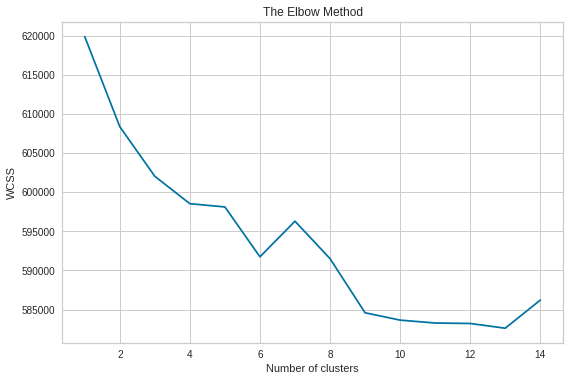

In [ ]:
plt.plot(range(1, 15), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

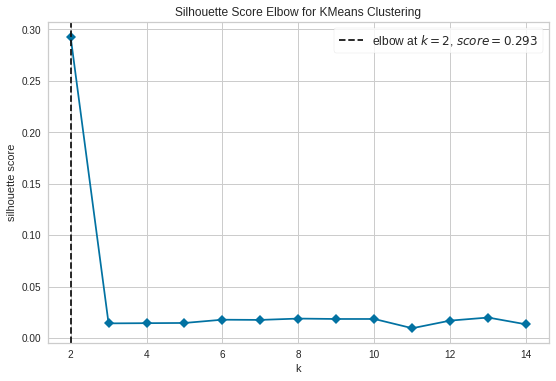

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=0)

visualizer = KElbowVisualizer(model, k=(2,15), metric='silhouette', timings=False)

visualizer.fit(clustering_policy1)    
visualizer.poof() 

In [ ]:
while True:pass